# Búsqueda de Expedientes Médicos usando Latent Semantic Analysis (LSA)

In [ ]:
!pip3 install nltk

In [ ]:
import pandas as pd
import numpy as np

from scipy.linalg import sqrtm

# Para preprocesar texto...
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

nltk.download('stopwords')
nltk.download('wordnet')  # WordNetLemmatizer

# Para construcción de bolsa de palabras ...
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrom2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pedrom2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Funciones auxiliares

In [3]:
def elimina_stopwords(texto):
  stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  nuevo_texto = stop.sub('', texto)
  return nuevo_texto

In [ ]:
def elimina_puntuacion(texto):
  nuevo_texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)  # Puntuación y todo lo que no sea letra ni números
  nuevo_texto = re.sub(" \d+", " ", nuevo_texto)   # Elimina números
  return nuevo_texto

In [5]:
lemmatizer = WordNetLemmatizer()

def lematizar(texto):
  texto=texto.split()
  nuevo_texto = " ".join([lemmatizer.lemmatize(i) for i in texto])
  return nuevo_texto

In [6]:
st = PorterStemmer()

def stemmer(texto):
  texto=texto.split()
  nuevo_texto =" ".join([st.stem(i) for i in texto])
  return nuevo_texto

In [7]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion(texto)
  texto = stemmer(texto)
  return(texto)

In [ ]:
def vectorizar_consulta(texto):
  ''' Regresa la consulta vectorizada con el mismo vocabulario que el corpus,
  y pesos tfidf en relación al corpus '''
  q = preprocesar(texto)
  q = tfidf.transform([q])
  q = q.toarray()
  return q


In [9]:
def reducir_vec_consulta (q):
  q_k = (q @ np.transpose(Vt_k)) @ (D_k)
  return q_k

In [ ]:
def descomposicion_k(U_k, D_k, Vt_k):
  ''' A partir de las tres matrices correspondientes a la  descomposición
  truncada en  valores singulares (donde k << r), devuelve dos matrices:
  la primera de tamaño n por k, y la segunda de dimensión k por d  '''
  MDT_n_k = np.matmul(U_k, sqrtm(D_k))
  MDT_k_d =  np.matmul(sqrtm(D_k), Vt_k)
  return MDT_n_k, MDT_k_d

In [11]:
def documentos_similares(q_vec, M, lim = 0):
  q_vec = q_vec.flatten()
  n = M.shape[0]
  sim_coseno = {}
  relevantes = {}
  # Calcular similitud coseno
  for i in range(n):
    sim_coseno[i] = np.dot(M[i,:], q_vec) / (np.linalg.norm(M[i,:]) * np.linalg.norm(q_vec))
    if sim_coseno[i] > lim:
      relevantes[i] = sim_coseno[i]
  if not relevantes:
    raise Exception( "No existen documentos similares", lim)

  #Ordenar valores
  relevantes_ordenados = {k:v for k, v in sorted(relevantes.items(),
                                                 key=lambda x: x[1],
                                                 reverse=True)}
  indices = list(relevantes_ordenados.keys())

  return corpus.loc[indices, :]

In [ ]:
def precision_sensibilidad(q, M, limites):
  doc_sim_dic = {}
  precision_dic = {}
  sensibilidad_dic = {}
  tolerancias_dic = {}

  for tol in limites:
    tolerancias_dic[tol] = tol
    df_similares = documentos_similares(q, M, lim = tol)
    doc_sim_dic[tol] =df_similares
    Dt = len(df_similares)                       # Documentos encontrados
    Dr = (df_similares['label']==clase_q).sum()  # Documentos relevantes encontrados
    Nr = (corpus['label']==clase_q).sum()   # Documentos relevantes en todo el corps

    # Documentos relevantes encontrados, entre todos los doc encontrados similares
    precision_dic[tol] = Dr / Dt

    # Documentos relevantes encontrados, entre todos los documentos en el corpus
    sensibilidad_dic[tol] = Dr / Nr   # (Recall)

  evaluacion = pd.DataFrame({'precision': precision_dic,
                           'sensibilidad': sensibilidad_dic
                           })
  evaluacion.plot.line(x= 'sensibilidad', y= 'precision',
                       title ='Precisión vs Sensibilidad',
                       xlim=(0,1), ylim=(0,1))

  plt.grid(alpha=.8, linestyle='--')
  plt.show()
  return evaluacion

## Lectura de datos

El conjunto completo de datos se encuentra en [OHSUMED dataset](https://www.mat.unical.it/OlexSuite/Datasets/SampleDataSets-about.htm). El dataset que utilizaremos está un poco preprocesado para quedarnos con resumenes textuales de enfermedades que están catalogadas en **23 categorías.**

In [ ]:
datos = pd.read_csv('./ohsumed_abstracts.csv',
                    usecols=[0,1,2], index_col = 0)

print(datos.shape)
datos.head()

(13924, 2)


,label,doc
0,16,Improved outcome at 28 days of age for very l...
1,5,Chylothorax after posterior spinal instrument...
2,16,Childhood pulmonary function following hyalin...
3,8,Treatment of atelectasis of upper lung lobes....
4,21,"Decision analysis, public health policy, and ..."


In [15]:
datos.loc[2,'doc']

' Childhood pulmonary function following hyaline membrane disease, Hyaline membrane disease per se is not associated with abnormal lung function or increased nonspecific airway reactivity in childhood or adulthood. Very-low-birth-weight infants who survive almost routinely in neonatal ICUs are at risk. however. for developing airflow obstruction and having airway hyperreactivity as children. and for having recurrent bouts of wheezing. cough. and respiratory infections. Neonates who develop BPD have the greatest risk of abnormal pulmonary function as children. Continued research into the prevention of premature birth and into the causes of neonatal lung injury. combined with improvements in the neonatal ICU and follow-up treatment. will undoubtedly contribute to improvement in the clinical course of premature infants.'

In [18]:
datos.loc[1,'doc']

' Chylothorax after posterior spinal instrumentation and fusion, Chylothorax occurred in a 16-year-old girl after posterior spinal fusion and instrumentation for idiopathic scoliosis. Nonoperative management. including chest tube drainage for 26 days and total parenteral nutrition. successfully treated this unusual complication after a posterior spinal fusion.'

In [19]:
len(datos['label'].value_counts())

23

Los documentos están catalogados en **23 categorías**.

In [ ]:
datos.sample(10, random_state=3)

,label,doc
5832,18,Alkaline phosphatase (tissue-nonspecific isoe...
12535,10,The community hospital-based stroke programs ...
151,23,Surgery in patients on long-term steroid ther...
11997,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
13010,21,Psychiatric diagnoses of treatment-seeking co...
3077,21,Clinical experience with the benzodiazepine a...
10659,23,The validity of canine platelet aggregometry ...
965,6,Evaluation of women with possible appendiciti...
8664,14,Heart rate adjustment of exercise-induced ST ...
6687,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [ ]:
# Separamos una muestra aleatoria de 10 documentos, que serán nuestras consultas
consultas_idx = datos.sample(10, random_state=3).index
consultas = datos.iloc[consultas_idx,:].copy()
consultas

,label,doc
5832,18,Alkaline phosphatase (tissue-nonspecific isoe...
12535,10,The community hospital-based stroke programs ...
151,23,Surgery in patients on long-term steroid ther...
11997,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
13010,21,Psychiatric diagnoses of treatment-seeking co...
3077,21,Clinical experience with the benzodiazepine a...
10659,23,The validity of canine platelet aggregometry ...
965,6,Evaluation of women with possible appendiciti...
8664,14,Heart rate adjustment of exercise-induced ST ...
6687,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [ ]:
# Dejamos el resto de documentos como nuestro corpus
corpus = pd.concat([datos,consultas]).drop_duplicates(keep=False).reset_index(drop=True)
consultas = consultas.reset_index(drop=True)
print(corpus.shape)
corpus

(13914, 2)


,label,doc
0,16,Improved outcome at 28 days of age for very l...
1,5,Chylothorax after posterior spinal instrument...
2,16,Childhood pulmonary function following hyalin...
3,8,Treatment of atelectasis of upper lung lobes....
4,21,"Decision analysis, public health policy, and ..."
...,...,...
13909,11,Results of blepharoptosis surgery with early ...
13910,11,"A century of cerebral achromatopsia, This rev..."
13911,11,Intraocular lens implantation after penetrati...
13912,11,Reproducibility of topographic measurements o...


In [23]:
consultas

,label,doc
0,18,Alkaline phosphatase (tissue-nonspecific isoe...
1,10,The community hospital-based stroke programs ...
2,23,Surgery in patients on long-term steroid ther...
3,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
4,21,Psychiatric diagnoses of treatment-seeking co...
5,21,Clinical experience with the benzodiazepine a...
6,23,The validity of canine platelet aggregometry ...
7,6,Evaluation of women with possible appendiciti...
8,14,Heart rate adjustment of exercise-induced ST ...
9,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


## Preprocesamiento de texto

In [24]:
ejemplo = np.random.choice(corpus['doc'])
print(len(ejemplo))
ejemplo

1755


' Effects of specific mu and kappa opiate tolerance and abstinence on hypothalamo-pituitary-adrenal axis secretion in the rat, Chronic administration of opiates to rats results in HPA axis tolerance and abstinence-induced hypersecretion. The effects of specific mu and kappa tolerance and withdrawal on the functional secretion of the HPA axis were evaluated in this study. Adult male rats were injected s.c. twice daily with saline. morphine or U50.488 for 5 days. Serum adrenocorticotrophic hormone (ACTH) or corticosterone (CS) were determined by radioimmunoassay as measures of HPA axis function. Tolerance to morphine (10 mg/kg) and U50.488 (1 mg/kg). but no cross-tolerance. was observed suggesting the development of mu- or kappa-specific tolerance. respectively. Tolerance does not occur at the pituitary or adrenal levels after these paradigms because ACTH and CS responses to exogenous corticotropin-releasing factor and ACTH. respectively. were not attenuated. CS secretion in response to 

**Transformarmos el texto a minúsculas...**

In [25]:
ejemplo = ejemplo.lower()
print(len(ejemplo))
ejemplo

1755


' effects of specific mu and kappa opiate tolerance and abstinence on hypothalamo-pituitary-adrenal axis secretion in the rat, chronic administration of opiates to rats results in hpa axis tolerance and abstinence-induced hypersecretion. the effects of specific mu and kappa tolerance and withdrawal on the functional secretion of the hpa axis were evaluated in this study. adult male rats were injected s.c. twice daily with saline. morphine or u50.488 for 5 days. serum adrenocorticotrophic hormone (acth) or corticosterone (cs) were determined by radioimmunoassay as measures of hpa axis function. tolerance to morphine (10 mg/kg) and u50.488 (1 mg/kg). but no cross-tolerance. was observed suggesting the development of mu- or kappa-specific tolerance. respectively. tolerance does not occur at the pituitary or adrenal levels after these paradigms because acth and cs responses to exogenous corticotropin-releasing factor and acth. respectively. were not attenuated. cs secretion in response to 

**Quitamos puntuación...**

In [26]:
ejemplo = elimina_puntuacion(ejemplo)
print(len(ejemplo))
ejemplo

1693


' effects of specific mu and kappa opiate tolerance and abstinence on hypothalamo pituitary adrenal axis secretion in the rat chronic administration of opiates to rats results in hpa axis tolerance and abstinence induced hypersecretion the effects of specific mu and kappa tolerance and withdrawal on the functional secretion of the hpa axis were evaluated in this study adult male rats were injected s c twice daily with saline morphine or u50  for  days serum adrenocorticotrophic hormone acth or corticosterone cs were determined by radioimmunoassay as measures of hpa axis function tolerance to morphine  mg kg and u50   mg kg but no cross tolerance was observed suggesting the development of mu or kappa specific tolerance respectively tolerance does not occur at the pituitary or adrenal levels after these paradigms because acth and cs responses to exogenous corticotropin releasing factor and acth respectively were not attenuated cs secretion in response to novelty stress was not affected b

**Quitamos palabras irrelevantes (_stopwords_)...**

In [27]:
ejemplo = elimina_stopwords(ejemplo)
print(len(ejemplo))
ejemplo

1342


' effects specific mu kappa opiate tolerance abstinence hypothalamo pituitary adrenal axis secretion rat chronic administration opiates rats results hpa axis tolerance abstinence induced hypersecretion effects specific mu kappa tolerance withdrawal functional secretion hpa axis evaluated study adult male rats injected c twice daily saline morphine u50  days serum adrenocorticotrophic hormone acth corticosterone cs determined radioimmunoassay measures hpa axis function tolerance morphine  mg kg u50   mg kg cross tolerance observed suggesting development mu kappa specific tolerance respectively tolerance occur pituitary adrenal levels paradigms acth cs responses exogenous corticotropin releasing factor acth respectively attenuated cs secretion response novelty stress affected either chronic opiate treatment circadian variation cs levels slightly blunted chronic morphine contrast elevation cs secretion quipazine   mg kg physostigmine   mg kg attenuated chronic u50  morphine administration

**Normalización del texto...**

Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la conversión de palabras en sus raíces.

In [28]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/pedrom2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
# Ejemplo de diferencia entre lematización y stemización (radicalización)
oracion = 'i have one foot and two feet constitutional'
print(lematizar(oracion))
print(stemmer(oracion))

i have one foot and two foot constitutional
i have one foot and two feet constitut


In [30]:
ejemplo_lema = lematizar(ejemplo)
print(len(ejemplo_lema))
ejemplo_lema

1305


'effect specific mu kappa opiate tolerance abstinence hypothalamo pituitary adrenal axis secretion rat chronic administration opiate rat result hpa axis tolerance abstinence induced hypersecretion effect specific mu kappa tolerance withdrawal functional secretion hpa axis evaluated study adult male rat injected c twice daily saline morphine u50 day serum adrenocorticotrophic hormone acth corticosterone c determined radioimmunoassay measure hpa axis function tolerance morphine mg kg u50 mg kg cross tolerance observed suggesting development mu kappa specific tolerance respectively tolerance occur pituitary adrenal level paradigm acth c response exogenous corticotropin releasing factor acth respectively attenuated c secretion response novelty stress affected either chronic opiate treatment circadian variation c level slightly blunted chronic morphine contrast elevation c secretion quipazine mg kg physostigmine mg kg attenuated chronic u50 morphine administration spontaneous antagonist pre

In [31]:
ejemplo_stem = stemmer(ejemplo)
print(len(ejemplo_stem))
ejemplo_stem

1109


'effect specif mu kappa opiat toler abstin hypothalamo pituitari adren axi secret rat chronic administr opiat rat result hpa axi toler abstin induc hypersecret effect specif mu kappa toler withdraw function secret hpa axi evalu studi adult male rat inject c twice daili salin morphin u50 day serum adrenocorticotroph hormon acth corticosteron cs determin radioimmunoassay measur hpa axi function toler morphin mg kg u50 mg kg cross toler observ suggest develop mu kappa specif toler respect toler occur pituitari adren level paradigm acth cs respons exogen corticotropin releas factor acth respect attenu cs secret respons novelti stress affect either chronic opiat treatment circadian variat cs level slightli blunt chronic morphin contrast elev cs secret quipazin mg kg physostigmin mg kg attenu chronic u50 morphin administr spontan antagonist precipit withdraw morphin u50 result elev cs level low dose morphin suppress morphin abstin induc cs hypersecret wherea u50 clonidin effect conclus alter

Juntamos todos estos pasos en la función auxiliar preprocesar.

In [32]:
%%time
corpus['doc_pp'] = corpus['doc'].apply(preprocesar)

CPU times: user 18.1 s, sys: 260 ms, total: 18.3 s
Wall time: 18.4 s


In [33]:
corpus.head()

,label,doc,doc_pp
0,16,Improved outcome at 28 days of age for very l...,improv outcom day age low birth weight infant ...
1,5,Chylothorax after posterior spinal instrument...,chylothorax posterior spinal instrument fusion...
2,16,Childhood pulmonary function following hyalin...,childhood pulmonari function follow hyalin mem...
3,8,Treatment of atelectasis of upper lung lobes....,treatment atelectasi upper lung lobe select br...
4,21,"Decision analysis, public health policy, and ...",decis analysi public health polici isoniazid c...


## Vectorización vía TF-IDF con scikit-learn

Usaremos la funcion **```TFidfVectorizer```** de sklearn.
Notar que el paramentro **```min_df```** hace la función "cut-off" para no considerar los términos con poca frecuencia en el documento.
En este ejercio se ha establecido una frecuencia de al menos 70 documentos que contengan el término que corresponde a cerca del 0.5% de todos los documentos


In [34]:
tfidf = TfidfVectorizer(min_df=30)
mdt_tfidf = tfidf.fit_transform(corpus['doc_pp'])
palabras = tfidf.get_feature_names_out()
MDT = pd.DataFrame(mdt_tfidf.todense(),
                              index=corpus.index,
                              columns=palabras)
print(MDT.shape)
MDT

(13914, 3418)


,a2,ab,abdomen,abdomin,aberr,abil,abl,ablat,abnorm,abolish,...,year,yet,yield,york,young,younger,yr,zero,zidovudin,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.068062,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144747,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.041414,0.0,0.0,0.0,0.079649,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
13912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ¿ Qué porcentaje de celdas tienen cero?

no_ceros = MDT.astype(bool).sum().sum()  # Cantidad de ceros en todo el dataframe
total = MDT.shape[0] * MDT.shape[1]

(1 - no_ceros/total) * 100

np.float64(98.27187412974779)

## Descomposición en valores singulares (SVD) con numpy

$~~ M = U~D~V^{T}$

$~~ M =
\sum_{i=1}^{min(m, n)}s_{i}\cdot u_{1}v_{i}^{T}
$






In [ ]:
%%time
# Vemos las dimensiones de las tres matrices
# Descomposición Matriz Documento Término  (3 min)
U_, sigma_, Vt_ = np.linalg.svd(MDT)

# Obtener con los valores singulares (sigma) la matriz D
D_ = np.diag(sigma_)

print(U_.shape, D_.shape, Vt_.shape)

(13914, 13914) (3418, 3418) (3418, 3418)
CPU times: user 6min 33s, sys: 13 s, total: 6min 46s
Wall time: 1min


In [41]:
D_

array([[2.05277892e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.08854544e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00154438e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.48546149e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.31332609e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.46647611e-15]])

In [42]:
sigma_.shape

(3418,)

In [ ]:
# ¿Cuántos valores de sigma son distintos de cero?
sigmas = sigma_[np.nonzero(sigma_)]
len(sigmas)

3418

In [44]:
print(min(sigma_))

2.4664761120190174e-15


In [45]:
# En el vector sigma estan ordenados los eigenvalores
sigma_

array([2.05277892e+01, 1.08854544e+01, 1.00154438e+01, ...,
       3.48546149e-01, 3.31332609e-01, 2.46647611e-15])

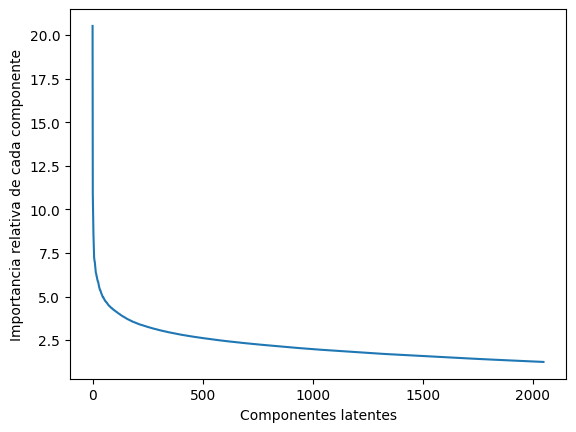

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 2049
sns.lineplot(x=list(range(len(sigma_[0:k]))), y = sigma_[0:k])
plt.ylabel('Importancia relativa de cada componente')
plt.xlabel('Componentes latentes')
plt.show()

## Análisis Semántico Latente
 SVD especificando $k<r$ con scipy


$ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\hat{M} = U_{k}~~D_{k}~~V_{k}^{T}
$

In [48]:
%%time
from scipy.sparse.linalg import svds
U_k, sigmas_k, Vt_k = svds(np.array(MDT), k=100)
D_k = np.diag(sigmas_k)

CPU times: user 3min 50s, sys: 1min 2s, total: 4min 52s
Wall time: 41 s


In [49]:
# docs-temas / relevancia temas / temas-doc

U_k.shape, D_k.shape, Vt_k.shape

((13914, 100), (100, 100), (100, 3418))


### Obtener la matriz reducida que representa a cada documento con k términos

$ M_{n\times{k}} = U_{k}~~\sqrt{D_{k}} $

In [50]:
M1 = np.matmul(U_k, sqrtm(D_k))
M1.shape

(13914, 100)

### Obtener la matriz reducida que representa a cada palabra con k términos
$ M_{k\times{d}} = \sqrt{D_{k}}~~{V_{k}}^T~~ $

In [51]:
M2 =  np.matmul(sqrtm(D_k), Vt_k)
M2.shape

(100, 3418)

Por facilidad la función auxiliar **```descomposicion_k()```** regresa las dos matrices obtenidas en las líneas anteriores



In [52]:
MDT_nk, MDT_kd = descomposicion_k(U_k, D_k, Vt_k )

print(MDT_nk.shape, MDT_kd.shape)

(13914, 100) (100, 3418)


In [ ]:
# Dimensiones de las matrices reducidas
(M1).shape, np.transpose(M2).shape

((13914, 100), (3418, 100))

## Vectorización de consultas


Debemos ahora vectorizar nuestra consulta utilizando el mismo vocabulario que el corpus

In [54]:
#podemos usar cualquier texto
q = vectorizar_consulta('heart disease')
q.shape

(1, 3418)

In [55]:
q

array([[0., 0., 0., ..., 0., 0., 0.]])

Como vemos, tenemos ahora la consulta con las d dimensiones que corresponden al vocabulario del corpus.



In [56]:
D_k

array([[ 4.2031701 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  4.21587919,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  4.22501491, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 10.01544382,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        10.88545435,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 20.52778921]])

**Ahora es necesario reducir el vector, usando nuestras matrices**

$\hat{q} =
q~V_{k}~D
$

In [57]:
q_k = (q @ np.transpose(Vt_k)) @ (D_k)
print(q.shape, np.transpose(Vt_k).shape, D_k.shape )
print(q_k.shape)

(1, 3418) (3418, 100) (100, 100)
(1, 100)


In [58]:
q_k

array([[ 0.21139781, -0.39806256,  0.05124794, -0.23359169, -0.14969256,
         0.13406538,  0.09856203, -0.14586863, -0.14573044, -0.2703732 ,
         0.16302025,  0.39883707, -0.01735148,  0.33529288, -0.15036919,
        -0.31707665, -0.00251087, -0.30645426,  0.15721836,  0.12628419,
         0.28857666, -0.23727581,  0.41050645,  0.33652779, -0.02287501,
        -0.02090499, -0.31191439,  0.26988977, -0.42767384, -0.09832261,
         0.04661019,  0.15325887, -0.31989763, -0.19322974, -0.51330177,
        -0.11674368, -0.08135457,  0.54187777,  0.03144098,  0.09790177,
        -0.15030717,  0.02357786, -0.17517126,  0.15457919,  0.86018563,
         0.37254764,  0.41942081,  0.33414777, -0.18844436,  0.06447331,
         0.28346068,  0.37186729,  0.19368328, -0.44339357, -0.22424719,
         0.3415243 ,  0.61565073, -0.14002166,  0.32210133, -0.15566803,
        -0.60175344,  0.12221413, -0.12007637,  0.01075957, -0.23321027,
         0.45653966,  0.0187308 ,  0.90568307, -0.5

Por facilidad guardamos el código anterior en la función auxiliar **```reducir_vec_consulta()```**



In [59]:
q_k = reducir_vec_consulta(q)
q_k.shape

(1, 100)

In [60]:
consultas

,label,doc
0,18,Alkaline phosphatase (tissue-nonspecific isoe...
1,10,The community hospital-based stroke programs ...
2,23,Surgery in patients on long-term steroid ther...
3,4,Primary Ewing sarcoma: follow-up with Ga-67 s...
4,21,Psychiatric diagnoses of treatment-seeking co...
5,21,Clinical experience with the benzodiazepine a...
6,23,The validity of canine platelet aggregometry ...
7,6,Evaluation of women with possible appendiciti...
8,14,Heart rate adjustment of exercise-induced ST ...
9,14,"Auto-PEEP during CPR. An ""occult"" cause of el..."


In [ ]:
# Elegimos uno de los diagnósticos como consulta,
# guardamos la clase y el texto
q_idx = 1
clase_q =consultas.loc[q_idx,'label']
Q = consultas.loc[q_idx,'doc']

print('Clase de la consulta:' , clase_q,'\n')
Q

Clase de la consulta: 10 



' The community hospital-based stroke programs in North Carolina, Oregon and New York--V. Stroke diagnosis: factors influencing the diagnostic evaluation of patients following acute stroke, Among the 4129 patients of the Community Hospital-based Stroke Program. 30% had an unspecified stroke diagnosis. Since specific diagnosis and. perhaps. eventual treatment. derives in part from diagnostic testing. we examined the effect of clinical condition. geographic and demographic factors on the incidence of certain diagnostic tests after acute stroke. In this multivariable analysis. race. sex. history of hypertension and history of diabetes did not influence the chance of having any test. but older age strongly reduced the chances of receiving extensive evaluation. When CT scanning was available. the utilization of a CT as well as other diagnostic studies including cerebral angiography. radionuclide brain scan. EEG and EKG was increased. The odds of receiving a CT scan increased if the patient 

In [ ]:
q = vectorizar_consulta(Q)  # Preprocesamos y vectorizamos
q_k = reducir_vec_consulta(q)  # Reducimos a k dimensiones
print ('Dimensión vector q  :', q.shape)
print ('Dimensión vector q_k:', q_k.shape)

Dimensión vector q  : (1, 3418)
Dimensión vector q_k: (1, 100)


## Búsqueda de documentos relevantes a la consulta

In [ ]:
tol = .2  # Valor a partir del que se considera un doc similar a la consulta, el limite o threshold

doc_sim = documentos_similares(q_k, MDT_nk, lim = tol)


Dt = len(doc_sim)                       # Documentos encontrados
Dr = (doc_sim['label']==clase_q).sum()  # Documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   # Documentos relevantes en todo el corps

# Documentos relevantes encontrados, entre todos los doc encontrados similares
precision = Dr / Dt

# Documentos relevantes encontrados, entre todos los doc relevantes en el corpus
sensibilidad = Dr / Nr   # Recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  4784
      Documentos relevantes encontrados:  708
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.15
                           Sensibilidad: 0.58


In [ ]:
tol = .2  # Valor a partir del que se considera un doc similar a la consulta

doc_sim = documentos_similares(q, MDT.to_numpy(), lim = tol)


Dt = len(doc_sim)                       # Documentos encontrados
Dr = (doc_sim['label']==clase_q).sum()  # Documentos relevantes encontrados
Nr = (corpus['label']==clase_q).sum()   # Documentos relevantes en todo el corps

# Documentos relevantes encontrados, entre todos los doc encontrados similares
precision = Dr / Dt

# Documentos relevantes encontrados, entre todos los docrelevantes en el corpus
sensibilidad = Dr / Nr   # Recall

print ('                 Documentos encontrados: ', Dt)
print ('      Documentos relevantes encontrados: ', Dr)
print ('Documentos relevantes en todo el corpus: ', Nr, '\n')

print ('                              Precisión: {:1.2f}'.format(precision))
print ('                           Sensibilidad: {:1.2f}'.format(sensibilidad))

                 Documentos encontrados:  43
      Documentos relevantes encontrados:  30
Documentos relevantes en todo el corpus:  1221 

                              Precisión: 0.70
                           Sensibilidad: 0.02


## Evaluación de la recuperación de información

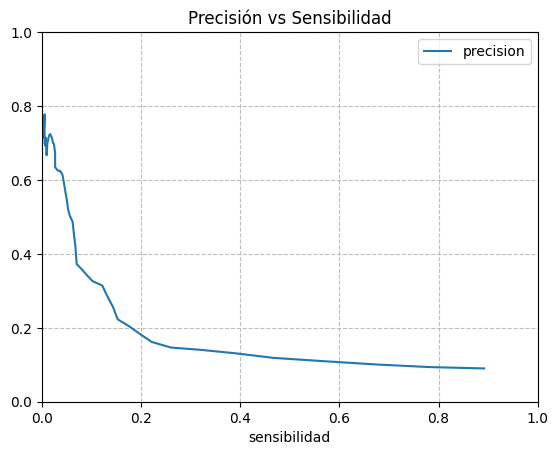

In [ ]:
tols = np.linspace(0.01, 0.3, 50)
evaluacion = precision_sensibilidad(q, MDT.to_numpy(),tols)

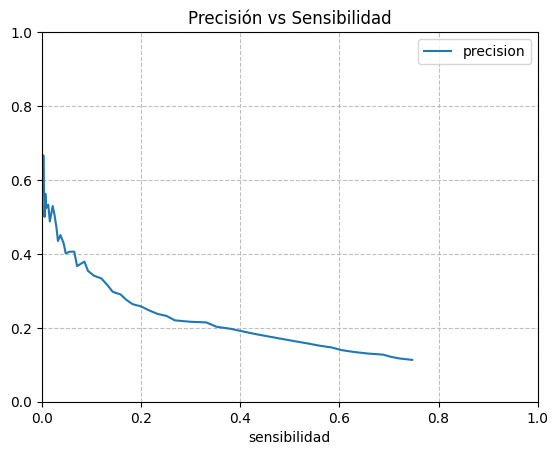

In [66]:
tols = np.linspace(0.15, 0.49, 50)
evaluacion_k = precision_sensibilidad(q_k, MDT_nk, tols)

In [67]:
eval = pd.merge(evaluacion_k, evaluacion, how='left', on= evaluacion.index, suffixes  = ('_k',''))
eval

,key_0,precision_k,sensibilidad_k,precision,sensibilidad
0,0.010000,0.113236,0.746929,0.090052,0.891892
1,0.015918,0.116983,0.721540,0.093729,0.782146
2,0.021837,0.121620,0.703522,0.100696,0.675676
3,0.027755,0.127447,0.687961,0.109656,0.569206
4,0.033673,0.130449,0.656839,0.118651,0.466830
5,0.039592,0.134869,0.628174,0.130767,0.392301
6,0.045510,0.139848,0.603604,0.140301,0.321048
7,0.051429,0.146702,0.584767,0.146611,0.260442
8,0.057347,0.151562,0.560197,0.161695,0.221949
9,0.063265,0.157819,0.535627,0.182296,0.199017


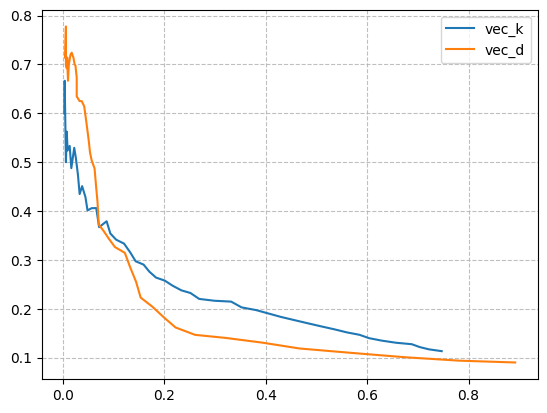

In [ ]:
figsize =(4,4)
plt.plot(eval['sensibilidad_k'], eval['precision_k'], label='Forma truncada')
plt.plot(eval['sensibilidad'],  eval['precision'], label='Forma entera')

plt.xlim=(.15,1)
plt.xlabel('sensibilidad')
plt.ylabel('precisión')

plt.legend()
plt.grid(alpha=.8, linestyle='--')
plt.show()